# Weather Analogue Validation Across 157 Events

This notebook analyzes the performance of different weather analogue search methods across 157 historical events. The analysis focuses on:

1. **SSR Analysis**: Computing the Sum of Squared Residuals (SSR) for precipitation forecasts using different analogue methods
2. **Global vs. Local Performance**: Comparing methods both globally (all grid points) and locally (important regions)
3. **Method Ranking**: Determining how frequently each method achieves the best performance
4. **Spread-Skill Relationship**: Analyzing the relationship between ensemble spread and forecast skill

The methods compared include:
- **AtmoDist**: Neural network-based analogue search
- **AtmoDist-SW**: Spatially weighted version of AtmoDist
- **Euclidean**: Traditional Euclidean distance similarity
- **Cosine**: Cosine similarity measure
- **SSIM**: Structural Similarity Index Measure

## Notebook Structure

1. **Setup and Data Loading**
   - Import libraries and configure environment
   - Load event data and grid weights
   - Load analogue search results

2. **Global SSR Analysis**
   - Calculate SSR for each method across all events
   - Compare overall performance

3. **Local SSR Analysis**
   - Focus on important regions using grid weights
   - Calculate and compare local SSR values

4. **Method Ranking**
   - Determine which methods perform best most frequently
   - Visualize ranking distributions

5. **Spread-Skill Analysis**
   - Analyze relationship between ensemble spread and forecast skill
   - Evaluate reliability of different methods

In [1]:
"""
This module contains the necessary imports for the weather analogue validation analysis.
The imports are organized by category for better readability.
"""

# Standard library imports
import copy
import json
import os
import random
import sys

# Data processing and analysis
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.stats import linregress
from scipy.spatial.distance import euclidean, cosine
from skimage.metrics import structural_similarity as ssim

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Deep learning framework for loading model results
import torch

# Set figure style for better visualization
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("talk")


In [2]:
"""
Setup environment and import project-specific utilities.
This cell configures the working directory and imports necessary utility functions.
"""

def setup_environment():
    """
    Set up the working environment by changing to the project root directory
    and adding project paths to sys.path.
    
    Returns:
        str: Current working directory
    """
    try:
        os.chdir("../")
    except:
        pass
    current_directory = os.getcwd()
    print("Current Directory:", current_directory)
    sys.path.append(os.path.abspath(os.path.join(current_directory, "notebooks")))
    return current_directory

# Set up environment
current_directory = setup_environment()

# Import project-specific utilities
from utils.utils import set_working_directory, load_json_config
from utils.utils_data import read_netcdf
from utils.utils_parsers import batch_data_parser, model_parser, feature_map_parser
from utils.utils_analog import generate_time_weights, cosine_similarity, euclidean_similarity, ssim_similarity, search_analogs, revise_analogs, attach_data_to_analogs, plot_analogs, plot_analogs_with_band

# Set seeds for reproducibility
def set_seeds(seed_value=11):
    """
    Set random seeds for reproducibility across different libraries.
    
    Args:
        seed_value (int): Seed value for random number generators
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    
# Set seeds for reproducibility
set_seeds(11)

Current Directory: /home/yuhan/Desktop/Master/yu-ml-weather-analogue


## Process Data


### - Load ERA5 Data

In [4]:
"""
Load ERA5 data with specified configuration parameters.
"""

def get_data_paths(variables, selected_frequency, time_unit, resample_method, preprocessing_method, year_range):
    """
    Generate file paths for ERA5 data with different preprocessing methods.
    
    Args:
        variables (str): String containing variable codes (e.g., 'd2muvmslr')
        selected_frequency (int): Data frequency
        time_unit (str): Time unit ('h' for hour)
        resample_method (str): Method used for resampling
        preprocessing_method (str): Preprocessing method applied to data
        year_range (tuple): Start and end year (inclusive)
        
    Returns:
        tuple: Paths for raw, standardized, and normalized data, and precipitation data
    """
    base_path = f"../data/processed/{variables}_{selected_frequency}{time_unit}_{resample_method}"
    raw_path = f"{base_path}_{preprocessing_method}_{year_range[0]}{year_range[1]}.h5"
    standardized_path = f"{base_path}_standardized_{year_range[0]}{year_range[1]}.h5"
    normalized_path = f"{base_path}_normalized_{year_range[0]}{year_range[1]}.h5"
    
    # Path for precipitation data
    prep_path = f"../data/processed/tp_{selected_frequency}{time_unit}_{resample_method}_{preprocessing_method}_{year_range[0]}{year_range[1]}.h5"
    
    return raw_path, standardized_path, normalized_path, prep_path

# Data configuration parameters
variables = "d2muvmslr"
variable_list = ["d2m", "u", "v", "msl", "r"]
selected_frequency = 1
time_unit = "h"
resample_method = "none"
preprocessing_method = "raw"
year_range = (2004, 2020)

# Generate data paths
all_variables_data_path, all_variables_standardized_data_path, all_variables_normalized_data_path, prep_path = get_data_paths(
    variables, selected_frequency, time_unit, resample_method, preprocessing_method, year_range
)

# Load precipitation data (which will be used for validation)
prep_data = read_netcdf(prep_path)

# Note: The following data is commented out as it's not used in this analysis
all_variables_data = read_netcdf(all_variables_data_path)
# all_variables_standardized_data = read_netcdf(all_variables_standardized_data_path)
# all_variables_normalized_data = read_netcdf(all_variables_normalized_data_path)

### - Load Events

In [5]:
"""
Load event data and grid weights for analysis.
"""

def load_events_data(events_path):
    """
    Load and preprocess historical events data.
    
    Args:
        events_path (str): Path to the events CSV file
        
    Returns:
        pandas.DataFrame: Processed events dataframe with datetime columns
    """
    events_df = pd.read_csv(events_path)
    # Sort events by start datetime in ascending order
    events_df = events_df.sort_values(by="start datetime")
    # Convert string datetime to pandas datetime objects
    events_df["start datetime"] = pd.to_datetime(events_df["start datetime"])
    events_df["end datetime"] = pd.to_datetime(events_df["end datetime"])
    return events_df

def load_grid_weights(weights_path, threshold=0.0030):
    """
    Load grid weights and identify important grid points based on threshold.
    
    Args:
        weights_path (str): Path to the weights JSON file
        threshold (float): Threshold for identifying important grid points
        
    Returns:
        tuple: Grid weights array and list of indices above threshold
    """
    with open(weights_path, 'r') as f:
        loaded_data = json.load(f)
    
    grid_weights = np.array(loaded_data['grid_weights'])
    
    # Identify important grid points (above threshold)
    flattened_grid_weights = grid_weights.ravel()
    indices_above_threshold = np.where(flattened_grid_weights > threshold)[0]
    local_indices_list = indices_above_threshold.tolist()
    
    return grid_weights, local_indices_list

# Load event data
events_df = load_events_data("data/raw/events_flood.csv")

# Load grid weights and identify important grid points
grid_weights, local_indices_list = load_grid_weights('data/raw/weights.json', threshold=0.0030)

### - Load Analogs Results


In [6]:
"""
Load analogue search results from different similarity methods.
"""

def load_analogs_results(project_name, methods):
    """
    Load analogue search results for multiple similarity methods.
    
    Args:
        project_name (str): Project name or phase identifier
        methods (list): List of similarity method names
        
    Returns:
        dict: Dictionary containing results for each method
    """
    directory = f'../data/analogs/{project_name}'
    os.makedirs(directory, exist_ok=True)
    
    all_results = {}
    for method in methods:
        file_path = f'{directory}/{method}.json'
        with open(file_path, 'r') as f:
            all_results[method] = json.load(f)
        print(f"Loaded {len(all_results[method])} analogue results for {method}")
    
    return all_results

# Configuration
project = "first_stage"
similarity_methods = [
    "atmodist_similarity",    # Neural network-based similarity
    "weighted_similarity",    # Spatially weighted neural network similarity
    "euclidean_similarity",   # Traditional Euclidean distance
    "cosine_similarity",      # Cosine similarity
    "ssim_similarity"         # Structural similarity index
]

# Method display names for plots
methods_name = ["AtmoDist", "AtmoDist-SW", "Euclidean", "Cosine", "SSIM"]

# Load analogue results for all methods
all_results = load_analogs_results(project, similarity_methods)

Loaded 157 analogue results for atmodist_similarity
Loaded 157 analogue results for weighted_similarity
Loaded 157 analogue results for euclidean_similarity
Loaded 157 analogue results for cosine_similarity
Loaded 157 analogue results for ssim_similarity


## SSD for rainfall prediction

## -Global

Loading data for method: atmodist_similarity
Loading data for method: weighted_similarity
Loading data for method: euclidean_similarity
Loading data for method: cosine_similarity
Loading data for method: ssim_similarity
Results for method 'atmodist_similarity' already exist. Loading from ../data/analogs/ssr_rainfall/atmodist_similarity_ssr.json.
Results for method 'weighted_similarity' already exist. Loading from ../data/analogs/ssr_rainfall/weighted_similarity_ssr.json.
Results for method 'euclidean_similarity' already exist. Loading from ../data/analogs/ssr_rainfall/euclidean_similarity_ssr.json.
Results for method 'cosine_similarity' already exist. Loading from ../data/analogs/ssr_rainfall/cosine_similarity_ssr.json.
Results for method 'ssim_similarity' already exist. Loading from ../data/analogs/ssr_rainfall/ssim_similarity_ssr.json.


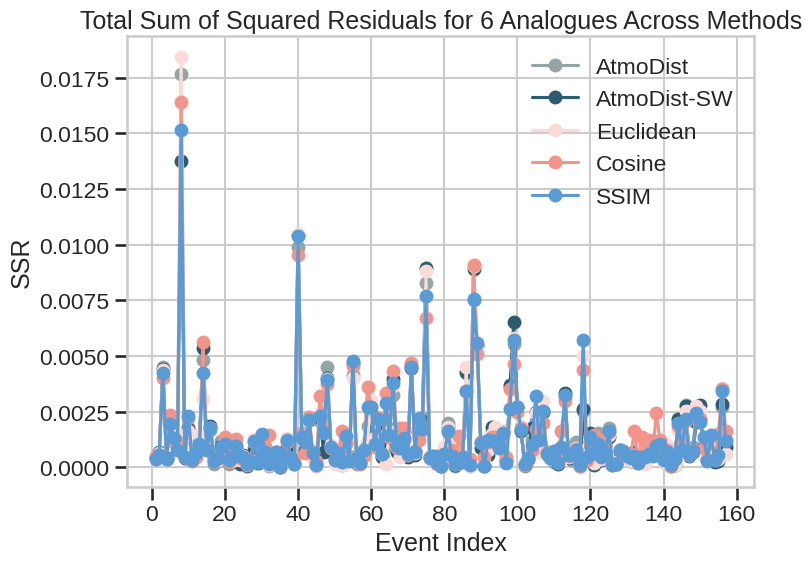

In [7]:
"""
Calculate global Sum of Squared Residuals (SSR) for different analogue methods.
SSR measures the performance of each method in predicting precipitation patterns.
"""

# 创建保存 SSR 结果的目录
directory = f'../data/analogs/{project}'
ssr_rainfall_directory = f'../data/analogs/ssr_rainfall'
os.makedirs(ssr_rainfall_directory, exist_ok=True)
color_palette = ['#95A5A6', '#2E5C6E',  '#FADBD8',  '#F1948A','#5B9BD5']  #'#F5B7B1',
methods_name = ["AtmoDist", "AtmoDist-SW","Euclidean", "Cosine", "SSIM"]

# 加载所有相似性方法的结果
for method in similarity_methods:
    print(f"Loading data for method: {method}")
    file_path = f'{directory}/{method}.json'
    with open(file_path, 'r') as f:
        all_results[method] = json.load(f)

def calculate_ssr_for_n_analogs(analogs, num_analogs=6):
    """
    Calculate the Sum of Squared Residuals (SSR) between the target data and the mean of n analogs.
    
    Args:
        analogs (dict): Dictionary containing target and analog data
        num_analogs (int): Number of analogs to use for calculation
        
    Returns:
        float: Total SSR across all grid points
    """
    keys = list(analogs.keys())
    data0 = np.squeeze(analogs[keys[0]]['data'])  # Target data (first analog)
    
    # Ensure all events have the same data length
    data_lengths = [len(analogs[k]['data']) for k in keys]
    assert all(length == data_lengths[0] for length in data_lengths), "All data lists must have the same length"
    
    # Use only available analogs if fewer than requested
    available_n = min(num_analogs, len(keys) - 1)  # keys[0] is the target
    
    # Get data for the first n analogs and calculate mean
    data_keys = [np.squeeze(analogs[keys[k]]['data']) for k in range(1, available_n + 1)]
    average_data = [np.mean([data[k] for data in data_keys], axis=0) for k in range(len(data0))]
    
    # Calculate SSR between target and mean analogs
    ssr_sum = np.zeros((32, 32))  # Initialize SSR sum matrix
    for array0, avg_array in zip(data0, average_data):
        ssr_sum += (array0 - avg_array) ** 2
    
    # Return sum of SSR across all grid points
    total_ssr_sum = np.sum(ssr_sum)
    return total_ssr_sum

def process_and_save_ssr(all_results, prep_data, ssr_directory, color_palette, methods_name):
    """
    Process all analogue results, calculate SSR, save results, and plot comparisons.
    
    Args:
        all_results (dict): Dictionary of analogue results for each method
        prep_data (dict): Precipitation data for validation
        ssr_directory (str): Directory to save SSR results
        color_palette (list): Colors for plotting different methods
        methods_name (list): Display names for methods in plots
        
    Returns:
        dict: Dictionary containing SSR values for each method
    """
    # Create directory for saving SSR results
    os.makedirs(ssr_directory, exist_ok=True)
    
    # Initialize dictionary to store SSR values for each method
    method_ssr_values = {method: [] for method in similarity_methods}
    
    # Process each method's analogue results
    for method, analogs_list in all_results.items():
        save_path = f'{ssr_directory}/{method}_ssr.json'
        
        # Check if results already exist
        if os.path.exists(save_path):
            print(f"Results for method '{method}' already exist. Loading from {save_path}.")
            with open(save_path, 'r') as f:
                method_ssr_values[method] = json.load(f)
            continue
        
        print(f"Processing method: {method}")
        for analogs in tqdm(analogs_list, desc=f"Calculating SSR for {method}"):
            if isinstance(analogs, dict):
                analogue_results_with_preprocessed_data = attach_data_to_analogs(prep_data, analogs)
                total_ssr = calculate_ssr_for_n_analogs(analogue_results_with_preprocessed_data)
                method_ssr_values[method].append(total_ssr)
            else:
                print(f"Unexpected data type in `analogs`: {type(analogs)}")
        
        # Save SSR results for current method
        with open(save_path, 'w') as f:
            json.dump(method_ssr_values[method], f)
        print(f"Saved SSR results for method '{method}' to {save_path}")
    
    # Plot SSR values for each method
    plot_ssr_comparison(method_ssr_values, color_palette, methods_name)
    
    return method_ssr_values

def plot_ssr_comparison(method_ssr_values, color_palette, methods_name):
    """
    Plot SSR comparison across different methods.
    
    Args:
        method_ssr_values (dict): Dictionary of SSR values for each method
        color_palette (list): Colors for different methods
        methods_name (list): Display names for methods
    """
    plt.figure(figsize=(8, 6))
    
    for idx, (method, ssr_values) in enumerate(method_ssr_values.items()):
        plt.plot(
            range(1, len(ssr_values) + 1), ssr_values,
            color=color_palette[idx % len(color_palette)],
            marker='o', linestyle='-',
            label=f'{methods_name[idx]}'
        )
    
    plt.xlabel('Event Index')
    plt.ylabel('SSR')
    plt.title('Total Sum of Squared Residuals for 6 Analogues Across Methods')
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

# Define color palette for consistent visualization
color_palette = ['#95A5A6', '#2E5C6E', '#FADBD8', '#F1948A', '#5B9BD5']

# Directory for saving SSR results
ssr_rainfall_directory = f'../data/analogs/ssr_rainfall'

# Calculate global SSR for all methods
method_ssr_values = process_and_save_ssr(
    all_results, 
    prep_data, 
    ssr_rainfall_directory, 
    color_palette, 
    methods_name
)


## - Local

Loading data for method: atmodist_similarity
Loading data for method: weighted_similarity
Loading data for method: euclidean_similarity
Loading data for method: cosine_similarity
Loading data for method: ssim_similarity
Local SSR results for method 'atmodist_similarity' already exist. Loading from ../data/analogs/ssr_rainfall_local/atmodist_similarity_ssr_local.json.
Local SSR results for method 'weighted_similarity' already exist. Loading from ../data/analogs/ssr_rainfall_local/weighted_similarity_ssr_local.json.
Local SSR results for method 'euclidean_similarity' already exist. Loading from ../data/analogs/ssr_rainfall_local/euclidean_similarity_ssr_local.json.
Local SSR results for method 'cosine_similarity' already exist. Loading from ../data/analogs/ssr_rainfall_local/cosine_similarity_ssr_local.json.
Local SSR results for method 'ssim_similarity' already exist. Loading from ../data/analogs/ssr_rainfall_local/ssim_similarity_ssr_local.json.


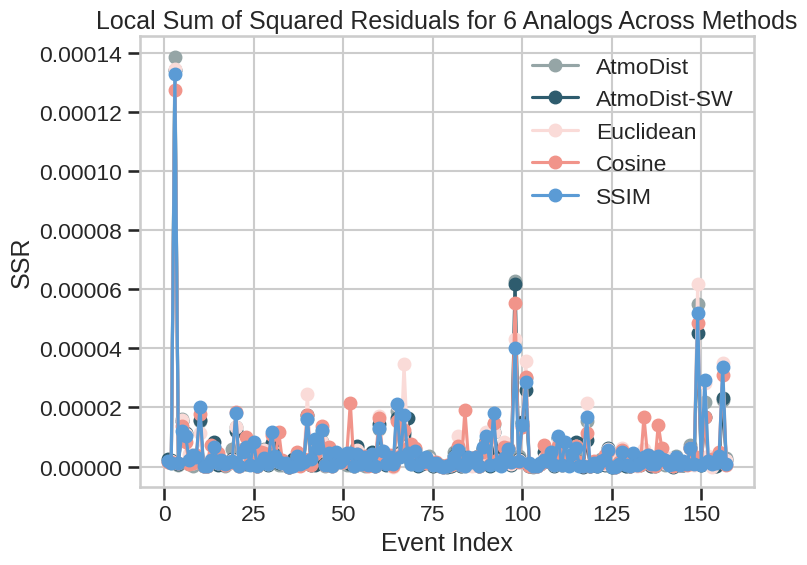

In [8]:
"""
Calculate local Sum of Squared Residuals (SSR) for different analogue methods.
This focuses on important grid points identified by the grid weights.
"""

# 创建保存 SSR 结果的目录
ssr_local_directory = f'../data/analogs/ssr_rainfall_local'
os.makedirs(ssr_local_directory, exist_ok=True)

color_palette = ['#95A5A6', '#2E5C6E',  '#FADBD8',  '#F1948A','#5B9BD5']  #'#F5B7B1',

# 加载所有相似性方法的结果
for method in similarity_methods:
    print(f"Loading data for method: {method}")
    file_path = f'{directory}/{method}.json'
    with open(file_path, 'r') as f:
        all_results[method] = json.load(f)

# 局部计算 SSR 的函数
def calculate_ssr_for_first_n_analogs_local(analogs, local_indices_list, num_analogs=6):
    """
    Calculate the Sum of Squared Residuals (SSR) between the target data and the mean of n analogs,
    focusing only on specified grid points.
    
    Args:
        analogs (dict): Dictionary containing target and analog data
        local_indices_list (list): List of indices for important grid points
        num_analogs (int): Number of analogs to use for calculation
        
    Returns:
        float: Total SSR across specified grid points
    """
    keys = list(analogs.keys())
    data0 = np.squeeze(analogs[keys[0]]['data'])  # Target data (first analog)
    
    # Ensure all events have the same data length
    data_lengths = [len(analogs[k]['data']) for k in keys]
    assert all(length == data_lengths[0] for length in data_lengths), "All data lists must have the same length"
    
    # Use only available analogs if fewer than requested
    available_n = min(num_analogs, len(keys) - 1)  # keys[0] is the target
    
    # Get data for the first n analogs and calculate mean
    data_keys = [np.squeeze(analogs[keys[k]]['data']) for k in range(1, available_n + 1)]
    average_data = [np.mean([data[k] for data in data_keys], axis=0) for k in range(len(data0))]
    
    # Initialize SSR sum for local indices only
    ssr_sum = np.zeros(len(local_indices_list))
    
    # Calculate SSR for specified grid points only
    for i, flat_idx in enumerate(local_indices_list):
        row, col = np.unravel_index(flat_idx, (32, 32))  # Convert 1D index to 2D coordinates
        for array0, avg_array in zip(data0, average_data):
            ssr_sum[i] += (array0[row, col] - avg_array[row, col]) ** 2
    
    # Return sum of SSR across specified grid points
    total_ssr_sum = np.sum(ssr_sum)
    return total_ssr_sum

def process_and_save_local_ssr(all_results, prep_data, local_indices_list, ssr_directory, color_palette, methods_name):
    """
    Process all analogue results, calculate local SSR, save results, and plot comparisons.
    
    Args:
        all_results (dict): Dictionary of analogue results for each method
        prep_data (dict): Precipitation data for validation
        local_indices_list (list): List of indices for important grid points
        ssr_directory (str): Directory to save local SSR results
        color_palette (list): Colors for plotting different methods
        methods_name (list): Display names for methods in plots
        
    Returns:
        dict: Dictionary containing local SSR values for each method
    """
    # Create directory for saving local SSR results
    os.makedirs(ssr_directory, exist_ok=True)
    
    # Initialize dictionary to store local SSR values for each method
    method_ssr_local_values = {method: [] for method in similarity_methods}
    
    # Number of analogs to use
    num_analogs = 6
    
    # Process each method's analogue results
    for method, analogs_list in all_results.items():
        local_save_path = f'{ssr_directory}/{method}_ssr_local.json'
        
        # Check if results already exist
        if os.path.exists(local_save_path):
            print(f"Local SSR results for method '{method}' already exist. Loading from {local_save_path}.")
            with open(local_save_path, 'r') as f:
                method_ssr_local_values[method] = json.load(f)
            continue
        
        print(f"Processing local SSR for method: {method}")
        for analogs in tqdm(analogs_list, desc=f"Calculating Local SSR for {method}"):
            if isinstance(analogs, dict):
                analogue_results_with_preprocessed_data = attach_data_to_analogs(prep_data, analogs)
                total_ssr = calculate_ssr_for_first_n_analogs_local(
                    analogue_results_with_preprocessed_data,
                    local_indices_list=local_indices_list,
                    num_analogs=num_analogs,
                )
                method_ssr_local_values[method].append(total_ssr)
            else:
                print(f"Unexpected data type in `analogs`: {type(analogs)}")
        
        # Save local SSR results for current method
        with open(local_save_path, 'w') as f:
            json.dump(method_ssr_local_values[method], f)
        print(f"Saved local SSR results for method '{method}' to {local_save_path}")
    
    # Plot local SSR values for each method
    plot_local_ssr_comparison(method_ssr_local_values, color_palette, methods_name)
    
    return method_ssr_local_values

def plot_local_ssr_comparison(method_ssr_local_values, color_palette, methods_name):
    """
    Plot local SSR comparison across different methods.
    
    Args:
        method_ssr_local_values (dict): Dictionary of local SSR values for each method
        color_palette (list): Colors for different methods
        methods_name (list): Display names for methods
    """
    plt.figure(figsize=(8, 6))
    
    for idx, (method, ssr_values) in enumerate(method_ssr_local_values.items()):
        plt.plot(
            range(1, len(ssr_values) + 1), ssr_values,
            color=color_palette[idx % len(color_palette)],
            marker='o', linestyle='-',
            label=f'{methods_name[idx]}'
        )
    
    plt.xlabel('Event Index')
    plt.ylabel('SSR')
    plt.title('Local Sum of Squared Residuals for 6 Analogs Across Methods')
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

# Directory for saving local SSR results
ssr_rainfall_local_directory = f'../data/analogs/ssr_rainfall_local'

# Calculate local SSR for all methods
method_ssr_local_values = process_and_save_local_ssr(
    all_results,
    prep_data,
    local_indices_list,
    ssr_rainfall_local_directory,
    color_palette,
    methods_name
)


## Ranking

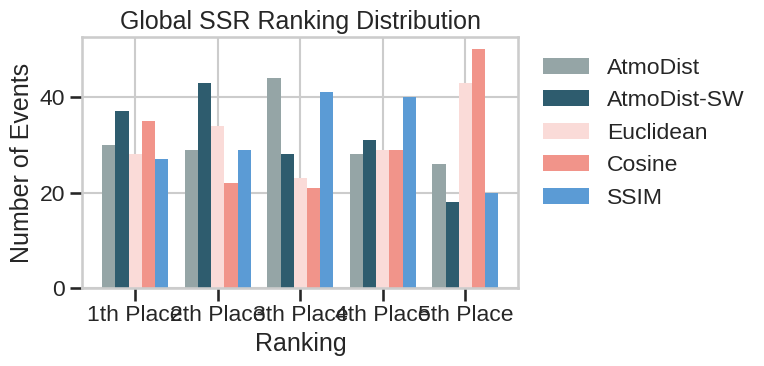

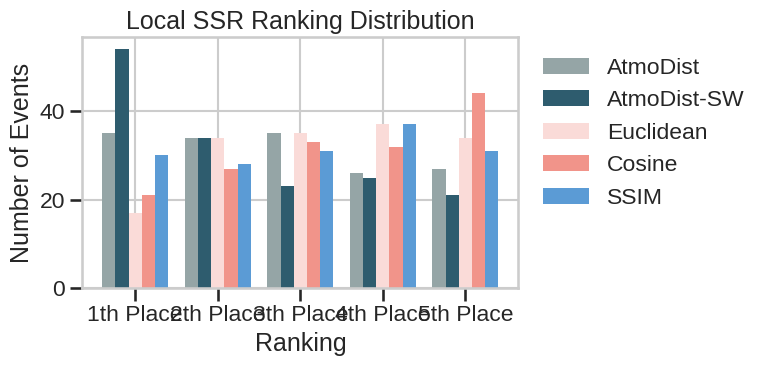

In [9]:
"""
Calculate and visualize method rankings based on global and local SSR performance.
Lower SSR indicates better performance (closer analogue match).
"""

import numpy as np
import matplotlib.pyplot as plt

def calculate_method_rankings(methods, global_ssr_values, local_ssr_values, min_length=None):
    """
    Calculate method rankings based on SSR performance for each event.
    
    Args:
        methods (list): List of method names
        global_ssr_values (dict): Dictionary of global SSR values for each method
        local_ssr_values (dict): Dictionary of local SSR values for each method
        min_length (int, optional): Minimum number of events to process. If None, use all events.
        
    Returns:
        tuple: Dictionaries of global and local ranking counts for each method
    """
    # Find minimum number of events across all methods if not specified
    if min_length is None:
        min_length = min(len(global_ssr_values[method]) for method in methods)
    
    # Initialize ranking count dictionaries
    ranking_counts_global = {method: [0] * len(methods) for method in methods}
    ranking_counts_local = {method: [0] * len(methods) for method in methods}
    
    # Process each event
    for event_idx in range(min_length):
        # Global SSR ranking
        event_ssr_global = [(method, global_ssr_values[method][event_idx]) for method in methods]
        event_ssr_global_sorted = sorted(event_ssr_global, key=lambda x: x[1])  # Sort by SSR (ascending)
        for rank, (method, _) in enumerate(event_ssr_global_sorted):
            ranking_counts_global[method][rank] += 1
            
        # Local SSR ranking
        event_ssr_local = [(method, local_ssr_values[method][event_idx]) for method in methods]
        event_ssr_local_sorted = sorted(event_ssr_local, key=lambda x: x[1])  # Sort by SSR (ascending)
        for rank, (method, _) in enumerate(event_ssr_local_sorted):
            ranking_counts_local[method][rank] += 1
            
    return ranking_counts_global, ranking_counts_local

def plot_ranking_distribution(ranking_counts, methods, methods_name, color_palette, title_prefix=""):
    """
    Plot the distribution of rankings for each method.
    
    Args:
        ranking_counts (dict): Dictionary of ranking counts for each method
        methods (list): List of method names
        methods_name (list): Display names for methods
        color_palette (list): Colors for different methods
        title_prefix (str): Prefix for plot title
    """
    # Prepare plot parameters
    labels = [f'{i + 1}th Place' for i in range(len(methods))]  # Rank labels
    x = np.arange(len(labels))  # x-axis positions
    width = 0.8 / len(methods)  # Bar width
    
    # Create plot
    fig, ax = plt.subplots(figsize=(8, 4))
    
    # Plot bars for each method
    for idx, method in enumerate(methods):
        ax.bar(
            x + idx * width,
            [ranking_counts[method][rank] for rank in range(len(methods))],
            width,
            label=methods_name[idx],
            color=color_palette[idx % len(color_palette)]
        )
    
    # Set plot labels and properties
    ax.set_xlabel('Ranking')
    ax.set_ylabel('Number of Events')
    ax.set_title(f'{title_prefix} SSR Ranking Distribution')
    ax.set_xticks(x + (len(methods) - 1) * width / 2)
    ax.set_xticklabels(labels)
    ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1))
    
    plt.tight_layout()
    plt.show()

# Calculate minimum number of events to process
min_length = 157  # All 157 flood events

# Calculate global and local rankings
ranking_counts_global, ranking_counts_local = calculate_method_rankings(
    similarity_methods,
    method_ssr_values,
    method_ssr_local_values,
    min_length
)

# Plot global ranking distribution
plot_ranking_distribution(
    ranking_counts_global,
    similarity_methods,
    methods_name,
    color_palette,
    "Global"
)

# Plot local ranking distribution
plot_ranking_distribution(
    ranking_counts_local,
    similarity_methods,
    methods_name,
    color_palette,
    "Local"
)


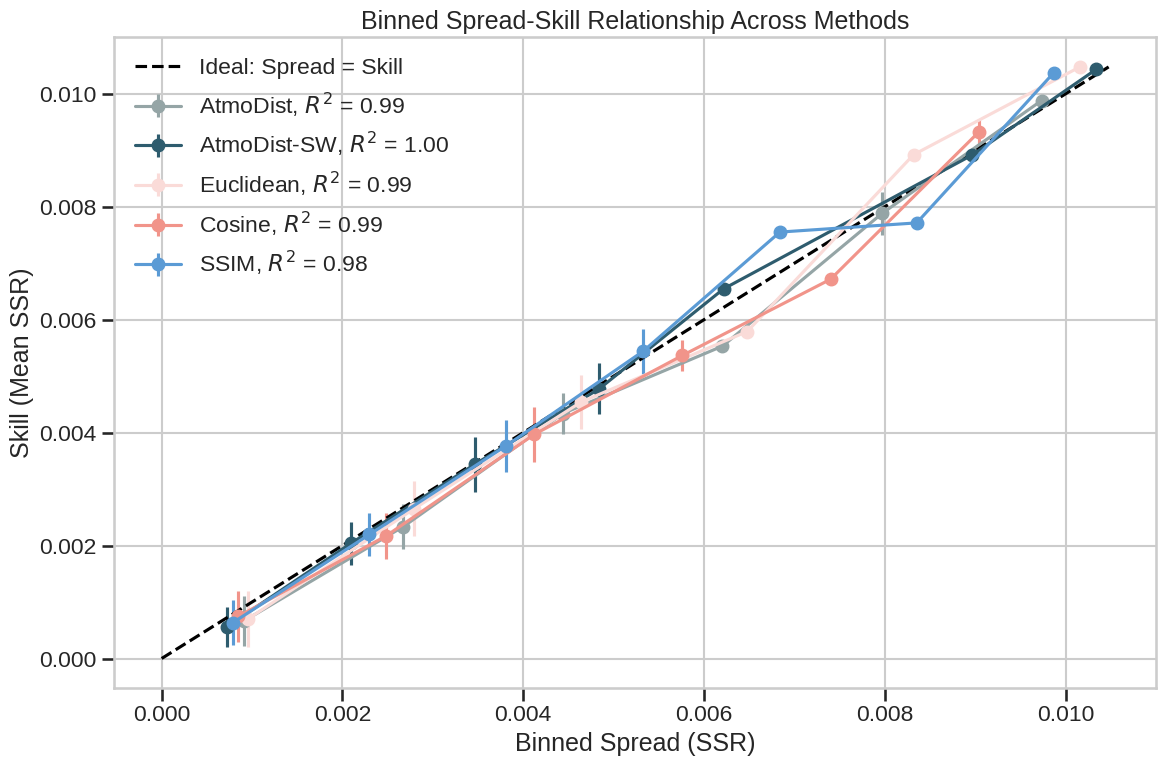

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

"""
Analyze the spread-skill relationship for different analogue methods.
The spread-skill relationship evaluates how well the ensemble spread (variability among analogs)
correlates with forecast skill (accuracy of prediction).
"""

def calculate_binned_spread_skill(ssr_values, num_bins=10):
    """
    Bin SSR values and calculate mean and standard deviation for each bin.
    This is used to analyze the spread-skill relationship.
    
    Args:
        ssr_values (list): List of SSR values
        num_bins (int): Number of bins to use
        
    Returns:
        tuple: Lists of bin centers, bin means, and bin standard deviations
    """
    ssr_values = np.array(ssr_values)
    
    # Remove NaN and Inf values
    valid_indices = np.isfinite(ssr_values)
    valid_ssr_values = ssr_values[valid_indices]
    
    # Create bins
    bins = np.linspace(np.min(valid_ssr_values), np.max(valid_ssr_values), num_bins + 1)
    bin_indices = np.digitize(valid_ssr_values, bins)
    
    bin_centers = []
    bin_means = []
    bin_stds = []
    
    # Calculate statistics for each bin
    for i in range(1, len(bins)):
        bin_mask = bin_indices == i
        bin_values = valid_ssr_values[bin_mask]
        
        if len(bin_values) > 0:
            bin_center = (bins[i - 1] + bins[i]) / 2
            bin_mean = np.mean(bin_values)
            bin_std = np.std(bin_values)
            
            bin_centers.append(bin_center)
            bin_means.append(bin_mean)
            bin_stds.append(bin_std)
    
    return bin_centers, bin_means, bin_stds

def plot_binned_spread_skill(method_ssr_values, color_palette, methods_name):
    """
    Create a binned spread-skill plot for all methods.
    
    Args:
        method_ssr_values (dict): Dictionary of SSR values for each method
        color_palette (list): Colors for different methods
        methods_name (list): Display names for methods
    """
    plt.figure(figsize=(12, 8))
    
    # Process each method
    for idx, (method, ssr_values) in enumerate(method_ssr_values.items()):
        # Calculate binned data
        bin_centers, bin_means, bin_stds = calculate_binned_spread_skill(ssr_values, num_bins=10)
        
        # Calculate regression statistics if enough data points
        if len(bin_centers) > 1:
            slope, intercept, r_value, p_value, std_err = linregress(bin_centers, bin_means)
            r2 = r_value**2
        else:
            r2 = np.nan
        
        # Plot with error bars
        plt.errorbar(
            bin_centers, bin_means, yerr=bin_stds,
            fmt='o-', color=color_palette[idx % len(color_palette)],
            label=f'{methods_name[idx]}, $R^2$ = {r2:.2f}' if not np.isnan(r2) else f'{methods_name[idx]}, $R^2$ = N/A'
        )
    
    # Add diagonal line (ideal relationship)
    max_val = max(max(bin_means) for _, bin_means, _ in 
                 [calculate_binned_spread_skill(v) for v in method_ssr_values.values()])
    plt.plot([0, max_val], [0, max_val], 'k--', label='Ideal: Spread = Skill')
    
    # Set plot properties
    plt.xlabel('Binned Spread (SSR)')
    plt.ylabel('Skill (Mean SSR)')
    plt.title('Binned Spread-Skill Relationship Across Methods')
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

# Create the binned spread-skill plot
plot_binned_spread_skill(method_ssr_values, color_palette, methods_name)